In [33]:
import numpy as np
import pandas as pd
import random

T = 1000
x_max = 1000
# P(D=1) distribution
Pd = [i/1000 for i in range(T + 1)]
# holding cost
h = 0.01
# purchase cost
c = 10
# selling price
p = 20
# order cost
K = 10

V = np.array([[float(0) for i in range(T + 1)] for j in range(x_max + 1)])
alpha = np.array([[float(0)for i in range(T + 1)] for j in range(x_max + 1)])

# initialized the last column: hx
V[:, -1] = [x * h for x in range(0, x_max + 1)] 


for t in range(T - 1, 0, -1):
    if t > 900:
        c = 0
    elif t > 500 and t <= 900:
        c = 15
    else: 
        c = 10

    dIsOne = Pd[t]
    dIsZero = round(1 - dIsOne, 3)
    # P(d=1) increases linearly as t increases
    d = random.choices([1, 0], weights=(dIsOne, dIsZero), k = 1)[0]
    
    if t > 900:
        # At t > 900 no order can be placed, so the optimal policy would be just a copy of optimal policy at t = 900
        for x in range(0, x_max):
            E = dIsOne * V[x - 1][t + 1] + dIsZero * V[x - 0][t + 1]  
            
            # items can only be sold
            V[x][t] = (-h * x)  + dIsOne * p + E

            # optimal policy remains unchanged after t = 900
            alpha[x][t]= alpha[x][t+1]

    # when  t <= 900
    else: 
        for x in range(0, x_max):
            Q = {}
            for a in range(max(d-x,0) , x_max - x + d):
                E = dIsOne * V[x - 1 + a][t + 1] + dIsZero * V[x - 0 + a][t + 1]
                order_cost = K if a > 0 else 0    
                Q[a] = (-h * x) - order_cost - (c * a)  + dIsOne * p + E
            V[x][t] = Q[max(d-x, 0)]
            alpha[x][t]= max(d-x, 0)
            for a in range(max(d-x,0), x_max-x+d):
                if(Q[a] > V[x][t]):
                    alpha[x][t]=a
                    V[x][t] = Q[a]



for i in range(x_max + 1):
    for j in range(990, T + 1):
        print(V[i][j],end=' ')
    print() 
print ('-------------------')





print('------------')

for i in range(x_max + 1):
    for j in range(990, T + 1):
        print(alpha[i][j], end = ' ')
    print()

print('------------')

for i in range(x_max + 1):
    for j in range(0, 11):
        print(V[i][j],end=' ')
    print() 

print('------------')

for i in range(x_max + 1):
    for j in range(0, 11):
        print(alpha[i][j], end = ' ')
    print()



20.0 20.0 20.0 20.00000000000005 20.000000000007176 20.000000001196398 20.000000239280002 20.00005982 20.019940000000002 29.97 0.0 
39.9898990927493 39.989909274929616 39.98991943662382 39.98992957797121 39.98993970915476 39.9899513275908 39.99021790144024 40.03958018006 49.90000001999999 19.97001 0.01 
59.96970756296525 59.96973807849261 59.96976853315573 59.96979897603637 59.96983497795624 59.97055972183074 60.058581979539525 69.79003004993999 39.91001 19.970010000000002 0.02 
79.93943566406068 79.93949663529939 79.9395576602299 79.93963450022744 79.94119530241309 80.07648981889052 89.64014984974023 59.81998 39.90001 19.97001 0.03 
99.89909362555183 99.89919566054292 99.899335472788 99.90225607029726 100.09273357158013 109.45044860049153 79.6999 59.799980000000005 39.890010000000004 19.970010000000002 0.04 
119.84869296866962 119.84892647321433 119.85389107571442 120.10663174744128 129.2210444088886 99.54974999999999 79.66990000000001 59.77998 39.88001 19.97001 0.05 
139.788399834625

184.48724999999993 166.24805000000003 147.99867999999998 129.73916 111.46951000000001 93.18975 74.8999 56.59998 38.29001 19.97001 1.6400000000000001 
184.39725 166.16805 147.92867999999999 129.67916000000002 111.41951 93.14975 74.8699 56.579980000000006 38.280010000000004 19.970010000000002 1.6500000000000001 
184.30725 166.08804999999998 147.85868000000005 129.61916 111.36951 93.10975 74.8399 56.55998 38.27001 19.970010000000002 1.6600000000000001 
184.21724999999998 166.00805000000005 147.78868 129.55916 111.31951000000001 93.06975 74.8099 56.53998 38.26001 19.970010000000002 1.67 
184.12725000000006 165.92804999999998 147.71868 129.49916000000002 111.26951 93.02974999999999 74.7799 56.519980000000004 38.25001 19.970010000000002 1.68 
184.03724999999997 165.84805 147.64868 129.43916 111.21951 92.98974999999999 74.7499 56.49998 38.24001 19.97001 1.69 
183.94725 165.76805000000002 147.57867999999996 129.37916 111.16950999999997 92.94975 74.71990000000001 56.47998 38.23001 19.9700100000

170.53724999999997 153.84805 137.14867999999998 120.43916 103.71951 86.98974999999999 70.2499 53.49998 36.74001 19.97001 3.19 
170.44725 153.76805 137.07868000000002 120.37915999999998 103.66950999999997 86.94975000000001 70.21990000000001 53.47998 36.73001 19.970010000000002 3.2 
170.35725 153.68805000000003 137.00867999999997 120.31915999999998 103.61951 86.90975 70.1899 53.45998 36.72001 19.97001 3.21 
170.26725000000005 153.60804999999996 136.93867999999998 120.25916000000001 103.56951000000001 86.86974999999998 70.15990000000001 53.439980000000006 36.71001 19.970010000000002 3.22 
170.17724999999996 153.52804999999998 136.86868 120.19916 103.51950999999997 86.82975000000002 70.1299 53.419979999999995 36.700010000000006 19.97001 3.23 
170.08724999999998 153.44805000000002 136.79868000000002 120.13915999999998 103.46951000000001 86.78975 70.09989999999999 53.39998000000001 36.69001 19.970010000000002 3.24 
169.99725000000004 153.36805 136.72867999999997 120.07916000000002 103.419509

158.65724999999998 143.28805 127.90868000000002 112.51915999999999 97.11951 81.70975000000001 66.2899 50.85998000000001 35.420010000000005 19.970010000000002 4.51 
158.56725 143.20805000000001 127.83867999999998 112.45916 97.06951000000002 81.66975 66.2599 50.839980000000004 35.41001 19.970010000000002 4.5200000000000005 
158.47725 143.12804999999997 127.76868 112.39916000000002 97.01950999999998 81.62975 66.22990000000001 50.81998 35.40001 19.97001 4.53 
158.38724999999994 143.04805 127.69868000000001 112.33915999999999 96.96951 81.58975000000002 66.19990000000001 50.799980000000005 35.390010000000004 19.970010000000002 4.54 
158.29725 142.96805 127.62868 112.27916 96.91951000000003 81.54975 66.1699 50.77998 35.38001 19.97001 4.55 
158.20725000000002 142.88805 127.55868000000001 112.21916000000003 96.86950999999999 81.50975 66.13990000000001 50.759980000000006 35.37001 19.97001 4.5600000000000005 
158.11724999999998 142.80805 127.48868000000002 112.15915999999999 96.81951 81.469750000

147.49725 133.36804999999995 119.22868000000001 105.07916000000002 90.91950999999999 76.74974999999998 62.56990000000002 48.37998 34.18001 19.970010000000002 5.75 
147.40724999999992 133.28805 119.15868 105.01915999999999 90.86950999999998 76.70975000000001 62.53990000000001 48.35998 34.170010000000005 19.970010000000002 5.76 
147.31725 133.20805000000001 119.08867999999998 104.95915999999998 90.81951000000002 76.66975000000001 62.5099 48.33998000000001 34.16001 19.970010000000002 5.7700000000000005 
147.22725000000003 133.12804999999997 119.01867999999999 104.89916000000001 90.76951 76.62975 62.479900000000015 48.31998 34.15001 19.97001 5.78 
147.13724999999997 133.04805 118.94868 104.83915999999999 90.71951 76.58975000000001 62.4499 48.299980000000005 34.140010000000004 19.970010000000002 5.79 
147.04725 132.96805 118.87867999999997 104.77916 90.66951000000002 76.54975 62.41990000000001 48.27998000000001 34.13001 19.97001 5.8 
146.95725000000002 132.88805 118.80868000000001 104.71916

136.60725 123.68805000000002 110.75868 97.81916000000001 84.86951 71.90975 58.9399 45.95998 32.97001 19.970010000000002 6.96 
136.51725000000002 123.60804999999999 110.68868000000002 97.75916000000001 84.81951 71.86975000000001 58.90990000000001 45.939980000000006 32.960010000000004 19.970010000000002 6.97 
136.42725 123.52805000000002 110.61868 97.69915999999999 84.76951 71.82975 58.879900000000006 45.91998000000001 32.950010000000006 19.970010000000002 6.98 
136.33725 123.44805 110.54867999999999 97.63915999999999 84.71951000000001 71.78975000000001 58.849900000000005 45.899980000000006 32.94001 19.970010000000002 6.99 
136.24725 123.36804999999998 110.47868 97.57916000000002 84.66951 71.74975 58.81990000000001 45.87998 32.93001 19.970010000000002 7.0 
136.15724999999998 123.28805 110.40868 97.51916 84.61951 71.70975 58.7899 45.85998 32.920010000000005 19.970010000000002 7.01 
136.06725 123.20805 110.33867999999998 97.45916000000001 84.56951000000001 71.66975 58.7599 45.8399800000000

123.28725 111.84804999999999 100.39868 88.93916000000002 77.46951 65.98975000000002 54.499900000000004 42.99998000000001 31.490010000000005 19.970010000000002 8.44 
123.19725 111.76805 100.32868 88.87916 77.41951 65.94975 54.46990000000001 42.97998000000001 31.480010000000004 19.970010000000002 8.45 
123.10725 111.68805000000002 100.25868 88.81916000000001 77.36951 65.90975 54.43990000000001 42.95998 31.470010000000002 19.97001 8.46 
123.01725 111.60804999999999 100.18868000000002 88.75916 77.31951 65.86975000000001 54.4099 42.939980000000006 31.460009999999997 19.970010000000002 8.47 
122.92724999999999 111.52805000000002 100.11868 88.69915999999999 77.26951 65.82975 54.379900000000006 42.919979999999995 31.450010000000002 19.970010000000002 8.48 
122.83725000000003 111.44805 100.04867999999998 88.63916 77.21951000000001 65.78975 54.34989999999999 42.89998 31.44001 19.970010000000002 8.49 
122.74725 111.36804999999998 99.97868000000001 88.57916000000002 77.16950999999999 65.7497499999

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.

0.0 4745.69512993895 4746.920811881063 4748.132195669747 4749.32930113772 4750.512148045834 4751.680756082903 4752.83514486548 4753.975333937595 4755.101342770432 4756.213190761975 
0.0 4751.339981165443 4752.57563598955 4753.796965529269 4755.003989594639 4756.196727914113 4757.37520013437 4758.539425820098 4759.68942445371 4760.825215435027 4761.946818080897 
0.0 4756.954538043015 4758.200162569596 4759.431431501541 4760.648364626636 4761.850981641546 4763.039302151632 4764.213345670736 4765.373131620907 4766.518679332084 4767.650008041731 
0.0 4762.535839781834 4763.791431050314 4765.032633454219 4766.259466760621 4767.4719506366 4768.670104649087 4769.853948264651 4771.023500849249 4772.178781667935 4773.3198098845205 
0.0 4768.081290636107 4769.3468460511085 4770.597976737675 4771.834702444728 4773.057042813435 4774.265017377075 4775.458645560853 4776.637946681681 4777.802939947921 4778.953644459092 
0.0 4773.588784138731 4774.864301594274 4776.1253563535065 4777.371968150624 4778

0.0 5437.149224492164 5439.744234492165 5442.324274492164 5444.889364492164 5447.439524492163 5449.974774492163 5452.495134492163 5455.000624492162 5457.491264492162 5459.967074492162 
0.0 5442.14922449216 5444.75423449216 5447.34427449216 5449.919364492161 5452.479524492161 5455.024774492161 5457.5551344921605 5460.07062449216 5462.57126449216 5465.05707449216 
0.0 5447.1492244921565 5449.764234492156 5452.364274492156 5454.949364492156 5457.519524492156 5460.074774492156 5462.615134492157 5465.140624492157 5467.651264492158 5470.147074492157 
0.0 5452.149224492157 5454.774234492157 5457.384274492158 5459.979364492157 5462.559524492158 5465.1247744921575 5467.675134492158 5470.210624492158 5472.731264492158 5475.237074492157 
0.0 5457.149224492158 5459.784234492158 5462.404274492158 5465.009364492159 5467.599524492159 5470.174774492159 5472.735134492158 5475.280624492158 5477.8112644921575 5480.327074492158 
0.0 5462.149224492154 5464.794234492154 5467.424274492154 5470.039364492154 5

0.0 6222.149224492279 6226.314234492279 6230.464274492279 6234.599364492279 6238.7195244922805 6242.824774492281 6246.915134492282 6250.990624492282 6255.051264492284 6259.097074492284 
0.0 6227.149224492429 6231.32423449243 6235.484274492431 6239.629364492432 6243.759524492431 6247.874774492432 6251.9751344924325 6256.060624492434 6260.131264492435 6264.187074492436 
0.0 6232.149224492753 6236.334234492753 6240.504274492753 6244.659364492754 6248.799524492756 6252.924774492758 6257.03513449276 6261.130624492763 6265.211264492766 6269.277074492769 
0.0 6237.149224493455 6241.344234493456 6245.524274493458 6249.68936449346 6253.839524493463 6257.974774493466 6262.09513449347 6266.2006244934755 6270.291264493481 6274.367074493487 
0.0 6242.149224494948 6246.354234494949 6250.544274494952 6254.719364494957 6258.879524494962 6263.02477449497 6267.155134494979 6271.2706244949895 6275.371264495002 6279.457074495016 
0.0 6247.149224498055 6251.364234498059 6255.564274498065 6259.749364498074 

0.0 5878.234999988429 5883.9850299884365 5889.705109988451 5895.395259988474 5901.055499988504 5906.685849988542 5912.286329988587 5917.85695998864 5923.397759988698 5928.9087499887655 
0.0 5868.254999993062 5874.0150299930665 5879.745109993076 5885.445259993089 5891.115499993107 5896.755849993129 5902.366329993157 5907.946959993189 5913.497759993225 5919.018749993265 
0.0 5858.274999995863 5864.045029995867 5869.7851099958725 5875.495259995881 5881.175499995892 5886.825849995906 5892.4463299959225 5898.036959995941 5903.597759995963 5909.128749995987 
0.0 5848.294999997552 5854.0750299975525 5859.825109997556 5865.545259997561 5871.235499997567 5876.895849997575 5882.526329997585 5888.126959997597 5893.69775999761 5899.238749997625 
0.0 5838.314999998556 5844.105029998558 5849.86510999856 5855.595259998563 5861.295499998567 5866.965849998573 5872.606329998578 5878.2169599985855 5883.797759998593 5889.348749998603 
0.0 5828.334999999161 5834.135029999161 5839.905109999162 5845.64525999

0.0 4411.175000000003 4418.395030000002 4425.585110000003 4432.745260000002 4439.875500000002 4446.975850000002 4454.046330000002 4461.086960000001 4468.0977600000015 4475.0787500000015 
0.0 4401.194999999998 4408.425029999998 4415.625109999997 4422.795259999997 4429.935499999998 4437.045849999998 4444.126329999998 4451.176959999998 4458.197759999998 4465.1887499999975 
0.0 4391.215000000001 4398.455030000001 4405.665110000001 4412.845260000001 4419.9955 4427.11585 4434.20633 4441.266960000001 4448.297760000001 4455.298750000002 
0.0 4381.235000000001 4388.485030000001 4395.705110000001 4402.895260000001 4410.055500000001 4417.185850000002 4424.286330000001 4431.356960000001 4438.397760000002 4445.408750000002 
0.0 4371.255000000003 4378.515030000003 4385.745110000003 4392.945260000001 4400.115500000002 4407.255850000001 4414.366330000002 4421.446960000001 4428.497760000001 4435.51875 
0.0 4361.275000000002 4368.545030000002 4375.7851100000025 4382.995260000002 4390.175500000002 4397.3

0.0 3203.595 3212.02503 3220.4251099999997 3228.79526 3237.1355 3245.44585 3253.72633 3261.9769600000004 3270.197760000001 3278.3887500000014 
0.0 3193.6150000000016 3202.0550300000014 3210.4651100000015 3218.8452600000014 3227.195500000001 3235.515850000001 3243.8063300000013 3252.066960000001 3260.2977600000013 3268.4987500000016 
0.0 3183.6350000000016 3192.0850300000016 3200.5051100000014 3208.8952600000016 3217.2555000000016 3225.5858500000018 3233.8863300000016 3242.156960000002 3250.397760000002 3258.608750000002 
0.0 3173.655000000001 3182.1150300000013 3190.545110000001 3198.945260000001 3207.315500000001 3215.655850000001 3223.966330000001 3232.2469600000013 3240.497760000001 3248.718750000001 
0.0 3163.6749999999993 3172.145029999999 3180.5851099999995 3188.9952599999992 3197.375499999999 3205.7258499999994 3214.046329999999 3222.336959999999 3230.5977599999997 3238.82875 
0.0 3153.695000000001 3162.175030000001 3170.6251100000004 3179.0452600000003 3187.4355 3195.79585 3204

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
0.0 0.0 0.

In [40]:
values_df = pd.DataFrame(V)
values_df

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,0.0,3808.151110,3808.231163,3808.301289,3808.361506,3808.411833,3808.452289,3808.482890,3808.503656,3808.517226,...,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.00006,20.01994,29.97000,0.00
1,0.0,3822.015216,3822.019004,3822.016434,3822.007372,3821.991691,3821.969276,3821.940019,3821.903820,3821.860567,...,39.989909,39.989919,39.989930,39.989940,39.989951,39.990218,40.03958,49.90000,19.97001,0.01
2,0.0,3833.941928,3833.953863,3833.957745,3833.953584,3833.941383,3833.921142,3833.892859,3833.856528,3833.812141,...,59.969738,59.969769,59.969799,59.969835,59.970560,60.058582,69.79003,39.91001,19.97001,0.02
3,0.0,3845.273801,3845.295143,3845.307843,3845.311918,3845.307382,3845.294247,3845.272525,3845.242225,3845.203355,...,79.939497,79.939558,79.939635,79.941195,80.076490,89.640150,59.81998,39.90001,19.97001,0.03
4,0.0,3856.254592,3856.285583,3856.307582,3856.320608,3856.324678,3856.319805,3856.306006,3856.283294,3856.251680,...,99.899196,99.899335,99.902256,100.092734,109.450449,79.699900,59.79998,39.89001,19.97001,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.0,1706.595000,1716.525030,1726.425110,1736.295260,1746.135500,1755.945850,1765.726330,1775.476960,1785.197760,...,99.688050,89.758680,79.819160,69.869510,59.909750,49.939900,39.95998,29.97001,19.97001,9.96
997,0.0,1696.615000,1706.555030,1716.465110,1726.345260,1736.195500,1746.015850,1755.806330,1765.566960,1775.297760,...,99.608050,89.688680,79.759160,69.819510,59.869750,49.909900,39.93998,29.96001,19.97001,9.97
998,0.0,1686.635000,1696.585030,1706.505110,1716.395260,1726.255500,1736.085850,1745.886330,1755.656960,1765.397760,...,99.528050,89.618680,79.699160,69.769510,59.829750,49.879900,39.91998,29.95001,19.97001,9.98
999,0.0,1676.655000,1686.615030,1696.545110,1706.445260,1716.315500,1726.155850,1735.966330,1745.746960,1755.497760,...,99.448050,89.548680,79.639160,69.719510,59.789750,49.849900,39.89998,29.94001,19.97001,9.99


In [39]:
policy = pd.DataFrame(alpha)
policy

,0,1,2,3,4,5,6,7,8,9,...,991,992,993,994,995,996,997,998,999,1000
0,0.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,10.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0



### Choose appropriate X and A  use dynamic programming (programmed in 
python) to determine the total expected profit and the optimal order policy, 
starting with 0 inventory at time 0

- X(state) is  the current number of items in inventory max value of which can be
     x_max(currently 10 is used for simplicity of understanding) - current level + demand
- A(action) is placing an order 

### Part B

In [36]:
import matplotlib.pyplot as plt

def plotter(Z, T, S, title):
    x = np.arange(0,T+1)
    y = np.arange(0,S+1)
    X,Y = np.meshgrid(x, y)
    fig = plt.figure(figsize=(7, 4), dpi=80)
    ax = fig.add_subplot(111)
    contour = ax.contourf(X, Y, Z, 20)
    fig.colorbar(contour)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("InventoryLevel", fontsize=12)
    plt.title(title, fontsize=14)
    plt.show()

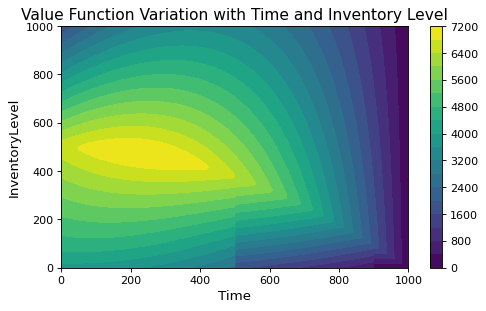

In [41]:
plotter(V, T, x_max, "Value Function Variation with Time and Inventory Level")

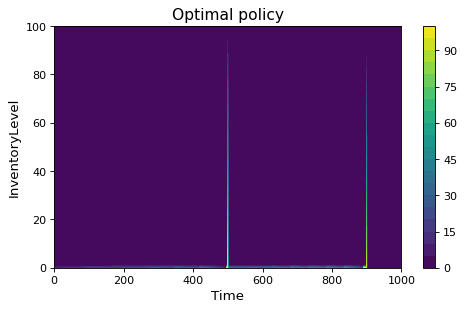

In [7]:
plotter(alpha, T, x_max, "Optimal policy")

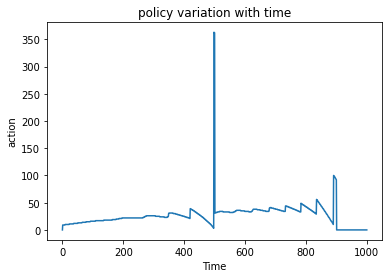

In [38]:
import matplotlib.pyplot as plt
   
policy =  alpha[0][:]
time_period = [t for t in range(T+1)] 
  
plt.plot(time_period, policy)
plt.title('policy variation with time')
plt.xlabel('Time')
plt.ylabel('action')
plt.show()

### Another version

In [ ]:
import numpy as np
import random

T = 100
x_max = 1000
# P(D=1) distribution
# Pd = [i/1000 for i in range(T + 1)]
# holding cost
h = 0.01
# purchase cost
c = 10
# selling price
p = 20
# order cost
K = 10

V = np.array([[float(0) for i in range(T)] for j in range(x_max + 1)])
alpha = np.array([[float(0)for i in range(T)] for j in range(x_max + 1)])

# initialized the last column: hx
V[:, -1] = [x * h for x in range(0, x_max + 1)] 


for t in range(T - 2, -1, -1):
    if t > 900:
        c = 0
    elif t > 500 and t <= 900:
        c = 15
    else: 
        c = 10

    dIsOne = t / 1000
    dIsZero = 1 - dIsOne
    # P(d=1) increases linearly as t increases
    d = random.choices([1, 0], weights=(dIsOne, dIsZero), k = 1)[0]
    
    if t > 900:
        # At t > 900 no order can be placed, so the optimal policy would be just a copy of optimal policy at t = 900
        for x in range(0, x_max+1):
            E = dIsOne * V[x - 1][t + 1] + dIsZero * V[x - 0][t + 1]  
            
            # items can only be sold
            V[x][t] = (-h * x)  + dIsOne * p + E

            # optimal policy remains unchanged after t = 900
            alpha[x][t]= alpha[x][t+1]

    # when  t <= 900
    else: 
        for x in range(0, x_max):
            Q = {}
            for a in range(max(d-x,0) , x_max - x + d):
                E = dIsOne * V[x - 1 + a][t + 1] + dIsZero * V[x - 0 + a][t + 1]
                    
                Q[a] = (-h * x) - K * (a > 1) - (c * a)  + dIsOne * p + E
            V[x][t] = Q[max(d-x, 0)]
            alpha[x][t]= max(d-x, 0)
            for a in range(max(d-x,0), x_max-x+d):
                if(Q[a] > V[x][t]):
                    alpha[x][t]=a
                    V[x][t] = Q[a]



for i in range(x_max + 1):
    for j in range(990, T):
        print(V[i][j],end=' ')
    print() 
print ('-------------------')



print('------------')

for i in range(x_max + 1):
    for j in range(990, T):
        print(alpha[i][j], end = ' ')
    print()

print('------------')

for i in range(x_max + 1):
    for j in range(0, 11):
        print(V[i][j],end=' ')
    print() 

print('------------')

for i in range(x_max + 1):
    for j in range(0, 11):
        print(alpha[i][j], end = ' ')
    print()


'''
Choose appropriate X and A  use dynamic programming (programmed in 
python) to determine the total expected profit and the optimal order policy, 
starting with 0 inventory at time 0

- X(state) is  the current number of items in inventory max value of which can be
     x_max(currently 10 is used for simplicity of understanding) - current level + demand
- A(action) is placing an order 



'''

In [ ]:
values_df = pd.DataFrame(V)
values_df

In [ ]:
import matplotlib.pyplot as plt

def plotter(Z, T, S, title):
    x = np.arange(0,T)
    y = np.arange(0,S+1)
    X,Y = np.meshgrid(x, y)
    fig = plt.figure(figsize=(7, 4), dpi=80)
    ax = fig.add_subplot(111)
    contour = ax.contourf(X, Y, Z, 20)
    fig.colorbar(contour)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("InventoryLevel", fontsize=12)
    plt.title(title, fontsize=14)
    plt.show()

In [ ]:
plotter(alpha, T, x_max, "Optimal policy")

#### new code

In [42]:
T = 1000
x_max = 100
# holding cost
h = 0.01
# purchase cost
c = 10
# selling price
p = 20
# order cost
K = 10
# Q = {}

V = np.array([[float(0) for i in range(T)] for j in range(x_max + 2)])
alpha = np.array([[float(0)for i in range(T)] for j in range(x_max + 2)])

# initialized the last column: hx
V[:, -1] = [x * h for x in range(0, x_max + 2)] 


for t in range(T - 2, -1, -1):
    c = 10 if t <= 500 else 15

    # P(D=1) distribution
    dIsOne = t / 1000
    dIsZero = 1 - dIsOne
    # P(d=1) increases linearly as t increases
    d = random.choices([1, 0], weights=(dIsOne, dIsZero), k = 1)[0]
    
    if t > 900:
        # At t > 900 no order can be placed, so the optimal policy would be just a copy of optimal policy at t = 900
        for x in range(0, x_max + 1):
            if x > 0:
                # reward only exists when x > 0 since no more action can be taken
                E = dIsOne * V[x - 1][t + 1] + dIsZero * V[x - 0][t + 1]  
                V[x][t] = (-h * x) + (dIsOne * p) + E
            else:
                # in case x = 0, x stays 0 for the rest of the time
                # Vx(t) = Vx(t+1) because no more profit can be made regardless the value of P(d=1)
                V[x][t] = V[x][t + 1]  
            # optimal policy remains unchanged after t = 900
            alpha[x][t]= alpha[x][t+1]

    # when  t <= 900
    else: 
        for x in range(0, x_max + 1):
            Q = {}

            for a in range(max(d-x,0) , x_max - x + d + 1):
                E = dIsOne * V[x - 1 + a][t + 1] + dIsZero * V[x - 0 + a][t + 1] 
                Q[a] = (-h * x) - K * (a > 0) - (c * a)  + (dIsOne * p) + E

            V[x][t] = Q[max(d-x, 0)]
            alpha[x][t]= max(d-x, 0)
            for a in range(max(d-x,0), x_max-x+d):
                if(Q[a] > V[x][t]):
                    alpha[x][t]=a
                    V[x][t] = Q[a]
                    
                    
for i in range(x_max + 1):
    for j in range(990, T):
        print(V[i][j],end=' ')
    print() 
print ('-------------------')



print('------------')

for i in range(x_max + 1):
    for j in range(990, T):
        print(alpha[i][j], end = ' ')
    print()

print('------------')

for i in range(x_max + 1):
    for j in range(0, 11):
        print(V[i][j],end=' ')
    print() 

print('------------')

for i in range(x_max + 1):
    for j in range(0, 11):
        print(alpha[i][j], end = ' ')
    print()

0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 
19.989899092749294 19.98990927492961 19.98991943662313 19.989929577891473 19.989939698782006 19.9899497970012 19.98995940024 19.98985006 19.95002 0.01 
39.96970756296519 39.96973807848757 39.96976853267274 39.969798925549256 39.96982923696082 39.9698564569376 39.96937073976 39.87002 19.950020000000002 0.02 
59.93943566403459 59.93949663318941 59.93955747896989 59.939618103128474 59.939667260912344 59.9383237860612 59.75998 39.860020000000006 19.95002 0.03 
79.89909361812079 79.89919512632659 79.89929607415904 79.89936448194938 79.89641312334483 79.61988 59.73998 39.85002 19.950020000000002 0.04 
99.8486916015852 99.84884265218793 99.84891585514563 99.84328613148142 99.44969999999999 79.58988 59.71998000000001 39.84002 19.95002 0.05 
119.78823704995878 119.78828242927119 119.77853520242958 119.24941999999999 99.40969999999999 79.55988 59.69998000000001 39.830020000000005 19.950020000000002 0.06 
139.71741660063455 139.70169956560773 139.019019999

3406.836848430872 3406.996848430872 3407.1462226541485 3407.2849908032135 3407.4131723576093 3407.5307865741197 3407.637852487067 3407.7343889086837 3407.820414429565 3407.895947419198 3407.961006026566 
3416.1208143252684 3416.2908143252685 3416.450118220835 3416.59874573069 3416.7367163627055 3416.864049414065 3416.9807639714872 3417.0868789115043 3417.1824129008032 3417.2673843966227 3417.3418116472085 
3425.337295280223 3425.5172952802227 3425.6865316936955 3425.8450242507356 3425.9927924790845 3426.1298557042455 3426.256233049636 3426.3719434367877 3426.477005585581 3426.5714380145246 3426.6552590410693 
3434.4881211062775 3434.6781211062776 3434.8572918664504 3435.0256531241976 3435.1832244200205 3435.330025097594 3435.4660743038653 3435.59139098918 3435.7059939074334 3435.8099016162473 3435.903132477172 
3443.5743554991604 3443.7743554991603 3443.9634616689623 3444.141693750214 3444.3090712908265 3444.4656136450158 3444.611339973363 3444.7462692428853 3444.870420227123 3444.9838

In [45]:
values_df = pd.DataFrame(V)
values_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,3239.740619,3239.740619,3239.820673,3239.890799,3239.951017,3240.001345,3240.041801,3240.072404,3240.093171,3240.106929,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.00000,0.00
1,3253.594897,3253.604897,3253.608685,3253.606116,3253.597054,3253.581374,3253.558960,3253.529703,3253.493506,3253.450252,...,19.989899,19.989909,19.989919,19.989930,19.989940,19.989950,19.989959,19.98985,19.95002,0.01
2,3265.511351,3265.531351,3265.543286,3265.547168,3265.543006,3265.530804,3265.510562,3265.482277,3265.445944,3265.401555,...,39.969708,39.969738,39.969769,39.969799,39.969829,39.969856,39.969371,39.87002,19.95002,0.02
3,3276.832926,3276.862926,3276.884267,3276.896967,3276.901041,3276.896504,3276.883368,3276.861644,3276.831342,3276.792469,...,59.939436,59.939497,59.939557,59.939618,59.939667,59.938324,59.759980,39.86002,19.95002,0.03
4,3287.803513,3287.843513,3287.874503,3287.896502,3287.909528,3287.913596,3287.908723,3287.894923,3287.872209,3287.840594,...,79.899094,79.899195,79.899296,79.899364,79.896413,79.619880,59.739980,39.85002,19.95002,0.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,4016.484927,4017.454927,4018.411239,4019.353883,4020.282878,4021.198244,4022.100001,4022.988168,4023.862765,4024.723811,...,171.427780,152.528480,133.619020,114.699420,95.769700,76.829880,57.879980,38.92002,19.95002,0.97
98,4022.745389,4023.725389,4024.691670,4025.644251,4026.583151,4027.508392,4028.419992,4029.317971,4030.202348,4031.073143,...,171.347780,152.458480,133.559020,114.649420,95.729700,76.799880,57.859980,38.91002,19.95002,0.98
99,4028.973229,4029.963229,4030.939477,4031.901992,4032.850795,4033.785905,4034.707342,4035.615125,4036.509273,4037.389807,...,171.267780,152.388480,133.499020,114.599420,95.689700,76.769880,57.839980,38.90002,19.95002,0.99
100,4035.167471,4036.167471,4037.153685,4038.126133,4039.084835,4040.029811,4040.961080,4041.878661,4042.782574,4043.672838,...,171.187780,152.318480,133.439020,114.549420,95.649700,76.739880,57.819980,38.89002,19.95002,1.00


In [43]:
import matplotlib.pyplot as plt

def plotter(Z, T, S, title):
    x = np.arange(0,T)
    y = np.arange(0,S+2)
    X,Y = np.meshgrid(x, y)
    fig = plt.figure(figsize=(7, 4), dpi=80)
    ax = fig.add_subplot(111)
    contour = ax.contourf(X, Y, Z, 20)
    fig.colorbar(contour)
    plt.xlabel("Time", fontsize=12)
    plt.ylabel("InventoryLevel", fontsize=12)
    plt.title(title, fontsize=14)
    plt.show()

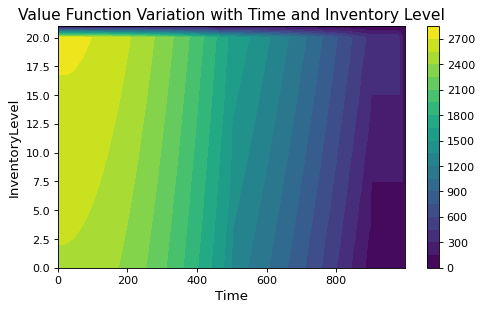

In [24]:
plotter(V, T, x_max, "Value Function Variation with Time and Inventory Level")

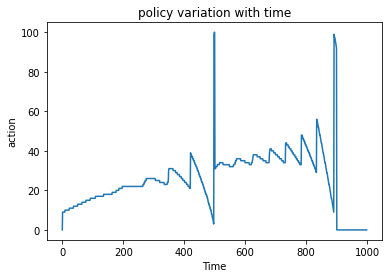

In [44]:
import matplotlib.pyplot as plt
   
policy =  alpha[0][:]
time_period = [t for t in range(T)] 
  
plt.plot(time_period, policy)
plt.title('policy variation with time')
plt.xlabel('Time')
plt.ylabel('action')
plt.show()